In [8]:
from math import sqrt
import pandas as pd
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM
from numpy import concatenate
import random
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/Users/alexellard/Downloads/scenarios_data.csv', header=0, index_col=0)
df

,reservoir_demand,node_1_demand,node_2_demand,node_3_demand,node_4_demand,node_5_demand,node_6_demand,node_7_demand,node_8_demand,node_9_demand,...,link_23_flow,link_24_flow,link_25_flow,link_26_flow,link_27_flow,link_28_flow,link_29_flow,link_30_flow,link_31_flow,link_32_flow
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,-3348.0,154.8,169.2,18.0,118.8,169.2,234.0,86.4,82.8,104.4,...,439.2,-205.2,-75.6,-18.0,118.8,68.4,7.2,-54.0,75.6,212.4
2017-01-01 00:30:00,-2959.2,136.8,147.6,18.0,108.0,144.0,237.6,79.2,75.6,90.0,...,392.4,-187.2,-72.0,-21.6,108.0,61.2,3.6,-54.0,72.0,183.6
2017-01-01 01:00:00,-2692.8,129.6,126.0,14.4,104.4,133.2,205.2,72.0,72.0,90.0,...,349.2,-176.4,-64.8,-18.0,93.6,50.4,3.6,-39.6,54.0,151.2
2017-01-01 01:30:00,-2379.6,104.4,100.8,10.8,86.4,122.4,180.0,68.4,57.6,82.8,...,316.8,-158.4,-54.0,-10.8,79.2,46.8,7.2,-32.4,50.4,140.4
2017-01-01 02:00:00,-2228.4,104.4,104.4,10.8,79.2,122.4,183.6,68.4,54.0,75.6,...,277.2,-144.0,-57.6,-18.0,72.0,39.6,7.2,-32.4,43.2,118.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 21:30:00,-5306.4,205.2,208.8,39.6,183.6,284.4,316.8,176.4,133.2,129.6,...,604.8,-259.2,32.4,115.2,169.2,100.8,10.8,-100.8,122.4,309.6
2017-12-31 22:00:00,-4910.4,208.8,183.6,39.6,154.8,252.0,295.2,165.6,133.2,133.2,...,565.2,-241.2,21.6,100.8,154.8,86.4,18.0,-75.6,100.8,288.0
2017-12-31 22:30:00,-4683.6,187.2,183.6,36.0,147.6,230.4,320.4,147.6,118.8,126.0,...,529.2,-226.8,21.6,100.8,147.6,86.4,14.4,-86.4,108.0,266.4


In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in, n_out, vars_to_predict=None):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i-1))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(n_out):
        cols.append(df[vars_to_predict].shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in vars_to_predict]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in vars_to_predict]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

# node 1 indexes
target_variable_demand_node1 = [1]
target_variable_pressures_node1 = [33]
target_variable_flows_node1 = [64]
#node 16 indexes
target_variable_demand_node16 = [16]
target_variable_pressures_node16 = [48]
target_variable_flows_node16 = [79]
#node 29 indexes
target_variable_demand_node29 = [29]
target_variable_pressures_node29 = [61]
target_variable_flows_node29 = [92]


reframed_demand_node1 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_demand_node1)
reframed_pressures_node1 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_pressures_node1)
reframed_flows_node1 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_flows_node1)

reframed_demand_node16 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_demand_node16)
reframed_pressures_node16 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_pressures_node16)
reframed_flows_node16 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_flows_node16)

reframed_demand_node29 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_demand_node29)
reframed_pressures_node29 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_pressures_node29)
reframed_flows_node29 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_flows_node29)

reframed_demand_node1 = reframed_demand_node1.drop(reframed_demand_node1.columns[1], axis=1)
reframed_pressures_node1 = reframed_pressures_node1.drop(reframed_pressures_node1.columns[33], axis=1)
reframed_flows_node1 = reframed_flows_node1.drop(reframed_flows_node1.columns[64], axis=1)

reframed_demand_node16 = reframed_demand_node16.drop(reframed_demand_node16.columns[16], axis=1)
reframed_pressures_node16 = reframed_pressures_node16.drop(reframed_pressures_node16.columns[48], axis=1)
reframed_flows_node16 = reframed_flows_node16.drop(reframed_flows_node16.columns[79], axis=1)

reframed_demand_node29 = reframed_demand_node29.drop(reframed_demand_node29.columns[29], axis=1)
reframed_pressures_node29 = reframed_pressures_node29.drop(reframed_pressures_node29.columns[61], axis=1)
reframed_flows_node29 = reframed_flows_node29.drop(reframed_flows_node29.columns[92], axis=1)

In [4]:
demands = [reframed_demand_node1, reframed_demand_node16, reframed_demand_node29]
pressures = [reframed_pressures_node1, reframed_pressures_node16, reframed_pressures_node29]
flows = [reframed_flows_node1, reframed_flows_node16, reframed_flows_node29]

parameters = [demands, pressures, flows]

In [5]:
MAE_scaled = []
RMSE_scaled = []
R2_scaled = []
MAE = []
RMSE = []
R2 = []
sensors_covered = []

for run in range(1,11):
    for parameter in parameters:
        for node in parameter:
            #select random columns to drop
            columns_to_drop = random.sample(list(node.columns), 8)
            # Drop the selected columns from the dataframe
            if node.columns[-1] in columns_to_drop:
                columns_to_drop.remove(node.columns[-1])
            node.drop(columns_to_drop, axis=1, inplace=True)
            print('Node shape: ', node.shape)

            # split into train and test sets
            values = node.values
            scaled = scaler.fit_transform(values)
            train, test = train_test_split(scaled, test_size=0.2, random_state=0)

            # split into input and outputs
            train_X, train_y = train[:, :-1], train[:, -1]
            test_X, test_y = test[:, :-1], test[:, -1]

           # reshape input to be 3D [samples, timesteps, features]
            train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
            test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
            print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

            model = Sequential()
            model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
            model.add(Dense(1))
            model.compile(loss='mae', optimizer='adam')
            # fit network
            model.fit(train_X, train_y, epochs=10, batch_size=128, validation_data=(test_X, test_y), verbose=0, shuffle=False)

            # make predictions on the test data
            y_pred = model.predict(test_X)
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

            test_y = test_y.reshape((len(test_y), 1))
            inv_test_y = concatenate((test_y, test_X[:, -96:]), axis=1)
            test_y_inverse = scaler.inverse_transform(inv_test_y)
            test_y_inverse = test_y_inverse[:,0]

            y_pred = y_pred.reshape((len(y_pred), 1))
            inv_y_pred = concatenate((y_pred, test_X[:, -96:]), axis=1)
            y_pred_inverse = scaler.inverse_transform(inv_y_pred)
            y_pred_inverse = y_pred_inverse[:,0]
            
            percentage_list = round(node.shape[1] / 96 * 100)
            sensors_covered.append(percentage_list)

            # evaluate scaled errors
            mae_inverse = mean_absolute_error(test_y_inverse, y_pred_inverse)
            MAE.append(mae_inverse)
            print('Mean Absolute Error:', mae_inverse)
            rmse_inverse = sqrt(mean_squared_error(test_y_inverse, y_pred_inverse))
            RMSE.append(rmse_inverse)
            print('RMSE: %.3f' % rmse_inverse)
            r2_inverse = r2_score(test_y_inverse, y_pred_inverse)
            R2.append(r2_inverse)
            print('R^2: %.3f' % r2_inverse)

Node shape:  (87600, 88)
(70080, 1, 87) (70080,) (17520, 1, 87) (17520,)

Mean Absolute Error: 180.09125
RMSE: 235.123
R^2: 0.972
Node shape:  (87600, 88)
(70080, 1, 87) (70080,) (17520, 1, 87) (17520,)
Mean Absolute Error: 125.82642
RMSE: 153.293
R^2: 0.990
Node shape:  (87600, 88)
(70080, 1, 87) (70080,) (17520, 1, 87) (17520,)
Mean Absolute Error: 61.392494
RMSE: 76.602
R^2: 0.997
Node shape:  (87600, 88)
(70080, 1, 87) (70080,) (17520, 1, 87) (17520,)
Mean Absolute Error: 2.4943817
RMSE: 3.346
R^2: 0.998
Node shape:  (87600, 88)
(70080, 1, 87) (70080,) (17520, 1, 87) (17520,)
Mean Absolute Error: 19.8959
RMSE: 23.913
R^2: 1.000
Node shape:  (87600, 88)
(70080, 1, 87) (70080,) (17520, 1, 87) (17520,)
Mean Absolute Error: 23.908913
RMSE: 26.891
R^2: 1.000
Node shape:  (87600, 88)
(70080, 1, 87) (70080,) (17520, 1, 87) (17520,)
Mean Absolute Error: 28.569489
RMSE: 31.821
R^2: 1.000
Node shape:  (87600, 89)
(70080, 1, 88) (70080,) (17520, 1, 88) (17520,)
Mean Absolute Error: 54.99469
R

Mean Absolute Error: 204.8758
RMSE: 263.117
R^2: 0.968
Node shape:  (87600, 33)
(70080, 1, 32) (70080,) (17520, 1, 32) (17520,)
Mean Absolute Error: 184.24223
RMSE: 239.184
R^2: 0.971
Node shape:  (87600, 33)
(70080, 1, 32) (70080,) (17520, 1, 32) (17520,)
Mean Absolute Error: 7.4064937
RMSE: 9.604
R^2: 0.986
Node shape:  (87600, 34)
(70080, 1, 33) (70080,) (17520, 1, 33) (17520,)
Mean Absolute Error: 63.102497
RMSE: 81.276
R^2: 0.997
Node shape:  (87600, 34)
(70080, 1, 33) (70080,) (17520, 1, 33) (17520,)
Mean Absolute Error: 3.063533
RMSE: 4.548
R^2: 0.993
Node shape:  (87600, 32)
(70080, 1, 31) (70080,) (17520, 1, 31) (17520,)
Mean Absolute Error: 26.373528
RMSE: 31.900
R^2: 0.999
Node shape:  (87600, 34)
(70080, 1, 33) (70080,) (17520, 1, 33) (17520,)
Mean Absolute Error: 2.3113053
RMSE: 2.503
R^2: 0.999
Node shape:  (87600, 33)
(70080, 1, 32) (70080,) (17520, 1, 32) (17520,)
Mean Absolute Error: 23.32481
RMSE: 27.723
R^2: 1.000
Node shape:  (87600, 33)
(70080, 1, 32) (70080,) (175

In [6]:
demand_errors_mae_node1 = MAE[::9]
demand_errors_mae_node16 = MAE[1::9]
demand_errors_mae_node29 = MAE[2::9]
pressure_errors_mae_node1 = MAE[3::9]
pressure_errors_mae_node16 = MAE[4::9]
pressure_errors_mae_node29 = MAE[5::9]
flow_errors_mae_node1 = MAE[6::9]
flow_errors_mae_node16 = MAE[7::9]
flow_errors_mae_node29 = MAE[8::9]

demand_errors_rmse_node1 = RMSE[::9]
demand_errors_rmse_node16 = RMSE[1::9]
demand_errors_rmse_node29 = RMSE[2::9]
pressure_errors_rmse_node1 = RMSE[3::9]
pressure_errors_rmse_node16 = RMSE[4::9]
pressure_errors_rmse_node29 = RMSE[5::9]
flow_errors_rmse_node1 = RMSE[6::9]
flow_errors_rmse_node16 = RMSE[7::9]
flow_errors_rmse_node29 = RMSE[8::9]

demand_errors_r2_node1 = R2[::9]
demand_errors_r2_node16 = R2[1::9]
demand_errors_r2_node29 = R2[2::9]
pressure_errors_r2_node1 = R2[3::9]
pressure_errors_r2_node16 = R2[4::9]
pressure_errors_r2_node29 = R2[5::9]
flow_errors_r2_node1 = R2[6::9]
flow_errors_r2_node16 = R2[7::9]
flow_errors_r2_node29 = R2[8::9]

demand_sensors_covered_node1 = sensors_covered[::9]
demand_sensors_covered_node16 = sensors_covered[1::9]
demand_sensors_covered_node29 = sensors_covered[2::9]
pressure_sensors_covered_node1 = sensors_covered[3::9]
pressure_sensors_covered_node16 = sensors_covered[4::9]
pressure_sensors_covered_node29 = sensors_covered[5::9]
flow_sensors_covered_node1 = sensors_covered[6::9]
flow_sensors_covered_node16 = sensors_covered[7::9]
flow_sensors_covered_node29 = sensors_covered[8::9]

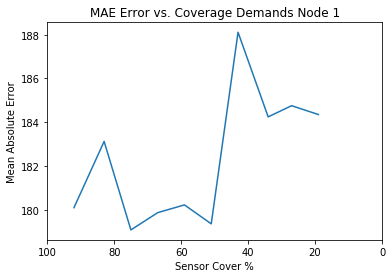

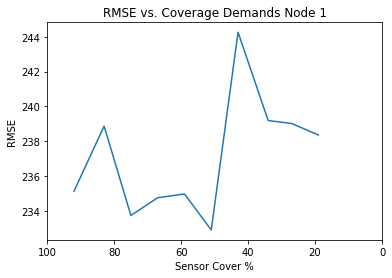

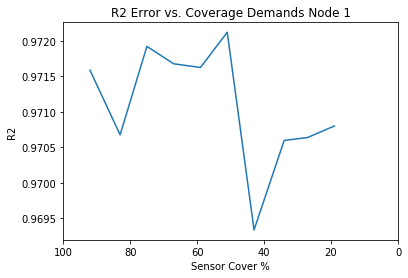

In [9]:
plt.plot(demand_sensors_covered_node1, demand_errors_mae_node1)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE Error vs. Coverage Demands Node 1")
plt.xlim([100, 0])
plt.show()

plt.plot(demand_sensors_covered_node1, demand_errors_rmse_node1)
plt.ylabel("RMSE")
plt.xlabel("Sensor Cover %")
plt.title("RMSE vs. Coverage Demands Node 1")
plt.xlim([100, 0])
plt.show()

plt.plot(demand_sensors_covered_node1, demand_errors_r2_node1)
plt.ylabel("R2")
plt.xlabel("Sensor Cover %")
plt.title("R2 Error vs. Coverage Demands Node 1")
plt.xlim([100, 0])
plt.show()

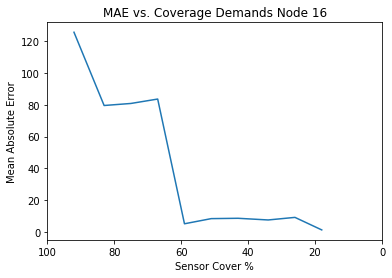

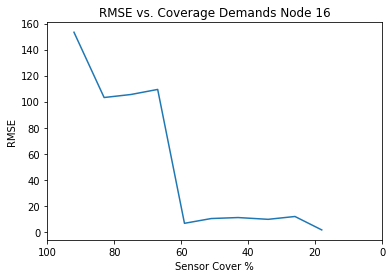

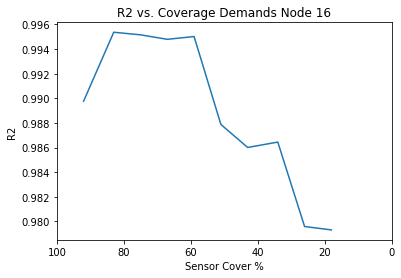

In [10]:
plt.plot(demand_sensors_covered_node16, demand_errors_mae_node16)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Demands Node 16")
plt.xlim([100, 0])
plt.show()

plt.plot(demand_sensors_covered_node16, demand_errors_rmse_node16)
plt.ylabel("RMSE")
plt.xlabel("Sensor Cover %")
plt.title("RMSE vs. Coverage Demands Node 16")
plt.xlim([100, 0])
plt.show()

plt.plot(demand_sensors_covered_node16, demand_errors_r2_node16)
plt.ylabel("R2")
plt.xlabel("Sensor Cover %")
plt.title("R2 vs. Coverage Demands Node 16")
plt.xlim([100, 0])
plt.show()

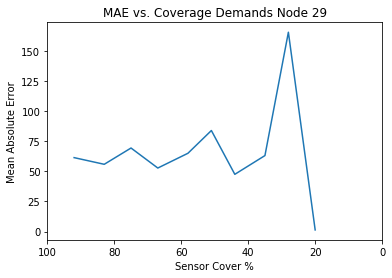

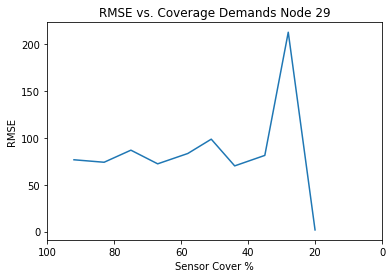

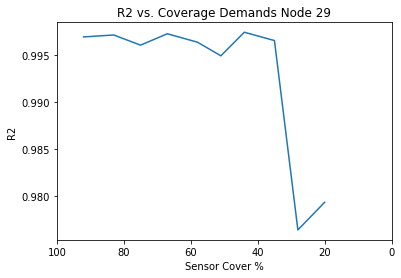

In [11]:
plt.plot(demand_sensors_covered_node29, demand_errors_mae_node29)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Demands Node 29")
plt.xlim([100, 0])
plt.show()

plt.plot(demand_sensors_covered_node29, demand_errors_rmse_node29)
plt.ylabel("RMSE")
plt.xlabel("Sensor Cover %")
plt.title("RMSE vs. Coverage Demands Node 29")
plt.xlim([100, 0])
plt.show()

plt.plot(demand_sensors_covered_node29, demand_errors_r2_node29)
plt.ylabel("R2")
plt.xlabel("Sensor Cover %")
plt.title("R2 vs. Coverage Demands Node 29")
plt.xlim([100, 0])
plt.show()

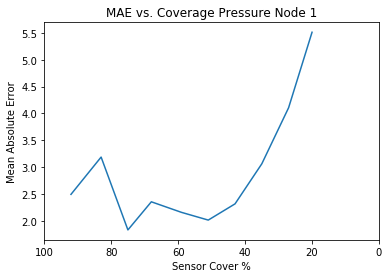

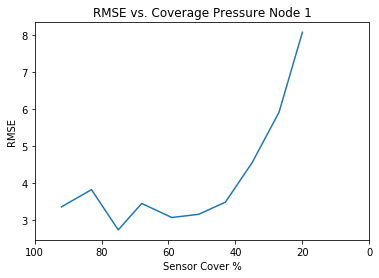

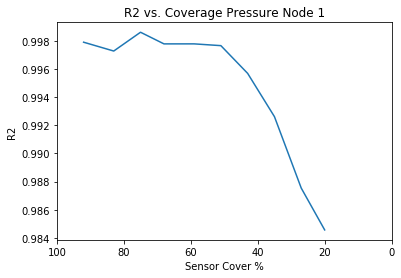

In [12]:
plt.plot(pressure_sensors_covered_node1, pressure_errors_mae_node1)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Pressure Node 1")
plt.xlim([100, 0])
plt.show()

plt.plot(pressure_sensors_covered_node1, pressure_errors_rmse_node1)
plt.ylabel("RMSE")
plt.xlabel("Sensor Cover %")
plt.title("RMSE vs. Coverage Pressure Node 1")
plt.xlim([100, 0])
plt.show()

plt.plot(pressure_sensors_covered_node1, pressure_errors_r2_node1)
plt.ylabel("R2")
plt.xlabel("Sensor Cover %")
plt.title("R2 vs. Coverage Pressure Node 1")
plt.xlim([100, 0])
plt.show()

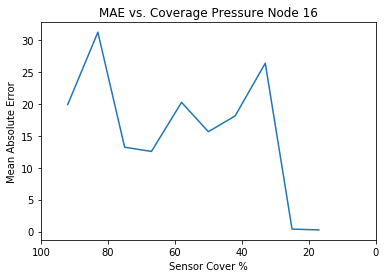

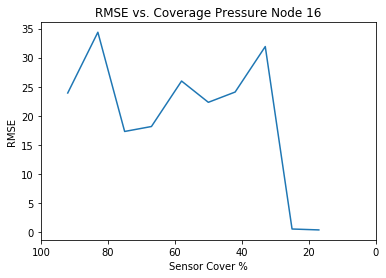

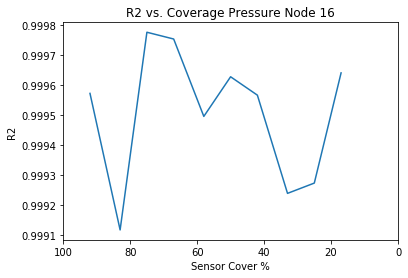

In [13]:
plt.plot(pressure_sensors_covered_node16, pressure_errors_mae_node16)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Pressure Node 16")
plt.xlim([100, 0])
plt.show()

plt.plot(pressure_sensors_covered_node16, pressure_errors_rmse_node16)
plt.ylabel("RMSE")
plt.xlabel("Sensor Cover %")
plt.title("RMSE vs. Coverage Pressure Node 16")
plt.xlim([100, 0])
plt.show()

plt.plot(pressure_sensors_covered_node16, pressure_errors_r2_node16)
plt.ylabel("R2")
plt.xlabel("Sensor Cover %")
plt.title("R2 vs. Coverage Pressure Node 16")
plt.xlim([100, 0])
plt.show()

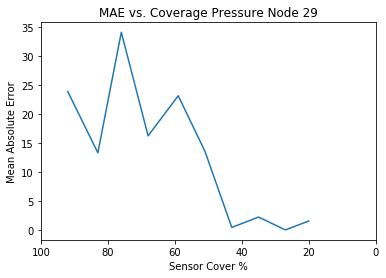

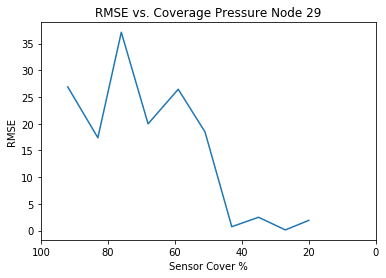

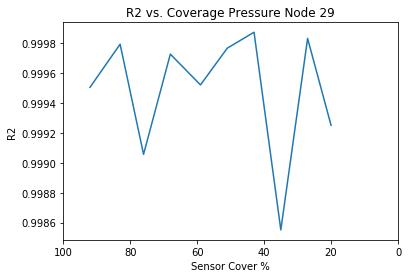

In [14]:
plt.plot(pressure_sensors_covered_node29, pressure_errors_mae_node29)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Pressure Node 29")
plt.xlim([100, 0])
plt.show()

plt.plot(pressure_sensors_covered_node29, pressure_errors_rmse_node29)
plt.ylabel("RMSE")
plt.xlabel("Sensor Cover %")
plt.title("RMSE vs. Coverage Pressure Node 29")
plt.xlim([100, 0])
plt.show()

plt.plot(pressure_sensors_covered_node29, pressure_errors_r2_node29)
plt.ylabel("R2")
plt.xlabel("Sensor Cover %")
plt.title("R2 vs. Coverage Pressure Node 29")
plt.xlim([100, 0])
plt.show()

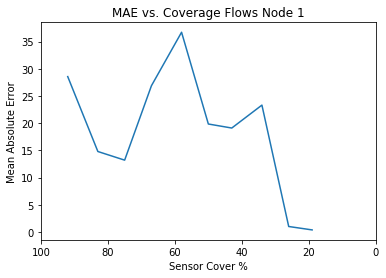

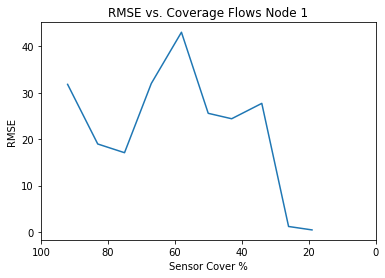

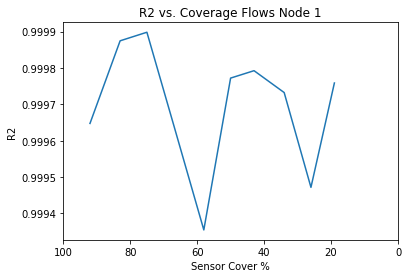

In [15]:
plt.plot(flow_sensors_covered_node1, flow_errors_mae_node1)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Flows Node 1")
plt.xlim([100, 0])
plt.show()

plt.plot(flow_sensors_covered_node1, flow_errors_rmse_node1)
plt.ylabel("RMSE")
plt.xlabel("Sensor Cover %")
plt.title("RMSE vs. Coverage Flows Node 1")
plt.xlim([100, 0])
plt.show()

plt.plot(flow_sensors_covered_node1, flow_errors_r2_node1)
plt.ylabel("R2")
plt.xlabel("Sensor Cover %")
plt.title("R2 vs. Coverage Flows Node 1")
plt.xlim([100, 0])
plt.show()

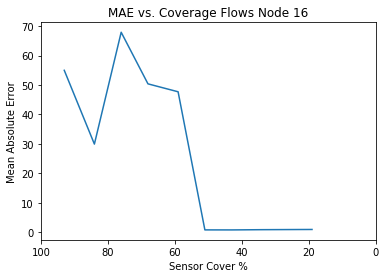

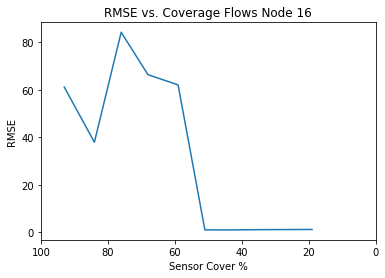

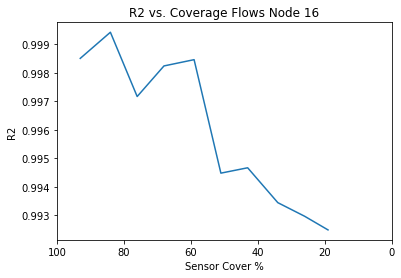

In [16]:
plt.plot(flow_sensors_covered_node16, flow_errors_mae_node16)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Flows Node 16")
plt.xlim([100, 0])
plt.show()

plt.plot(flow_sensors_covered_node16, flow_errors_rmse_node16)
plt.ylabel("RMSE")
plt.xlabel("Sensor Cover %")
plt.title("RMSE vs. Coverage Flows Node 16")
plt.xlim([100, 0])
plt.show()

plt.plot(flow_sensors_covered_node16, flow_errors_r2_node16)
plt.ylabel("R2")
plt.xlabel("Sensor Cover %")
plt.title("R2 vs. Coverage Flows Node 16")
plt.xlim([100, 0])
plt.show()

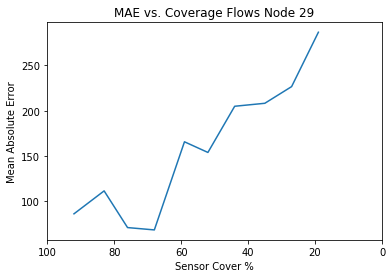

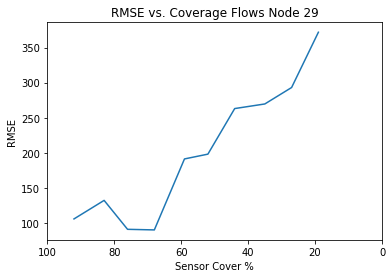

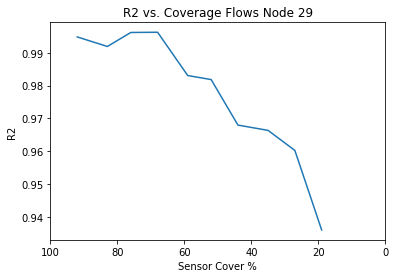

In [17]:
plt.plot(flow_sensors_covered_node29, flow_errors_mae_node29)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Flows Node 29")
plt.xlim([100, 0])
plt.show()

plt.plot(flow_sensors_covered_node29, flow_errors_rmse_node29)
plt.ylabel("RMSE")
plt.xlabel("Sensor Cover %")
plt.title("RMSE vs. Coverage Flows Node 29")
plt.xlim([100, 0])
plt.show()

plt.plot(flow_sensors_covered_node29, flow_errors_r2_node29)
plt.ylabel("R2")
plt.xlabel("Sensor Cover %")
plt.title("R2 vs. Coverage Flows Node 29")
plt.xlim([100, 0])
plt.show()